In [1]:
import numpy as np
import os
import pandas as pd
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import openpyxl
import matplotlib as mpl
import scipy as sp
from scipy import stats
from scipy import signal
from scipy import fft
from scipy import io
from scipy import interpolate
from scipy import optimize
from scipy import linalg
from scipy import integrate
from scipy.fft import dct

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{textcomp}',
    r'\usepackage{wasysym}']
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.size'] = 22
mpl.rcParams['font.family'] = 'STIXGeneral'

saveFigs = False

In [2]:
import sys 
import os
sys.path.append('../')

from BackDiffuse_LT import BackDiffuse
from GetCoreData_fct import GetCoreData



from Interpolation_Class import Interpolation

In [3]:
from HL_AnalyticThea_class import HL_Thea
from DiffusionProfiles_calculations import DiffusionLength

# Stability test: Interpolation Before Deconvolution

In [3]:
CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

coreNames = CoresSpecs['CoreName']


Sites = ['Crete','SiteA', 'SiteB','SiteE','SiteG']
i = 0

site=Sites[i]
core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb = CoreSpecs['dTamb']
dLaki = CoreSpecs['dLaki']


DataAll = GetCoreData(site)

data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
data_dens = DataAll[4]; data_dens_LT = DataAll[5]
data_diff = DataAll[6]; data_diff_LT = DataAll[7]


depth_LT = data_d18O_LT['depth']
d18O_LT = data_d18O_LT['d18O']



StabTest3 = pd.read_csv('../Data/'+site + '_DiffLensVdelta_InterpBF.txt', sep='\t')


maxDiff = max(np.diff(depth_LT))
minDiff = min(np.diff(depth_LT))
Delta0 = 0.11#(maxDiff + minDiff)/2 

N_yrs = 32

theoMins = [7.28,6.52,6.43,7.50,7.66]
theoMaxs = [7.49,6.70,6.61,7.76,7.88]
theoMax = theoMaxs[i]
theoMin = theoMins[i]

maxDiff = max(np.diff(depth_LT))
minDiff = min(np.diff(depth_LT))



s_deltas = (2 * (StabTest3['deltas']**2)/(np.pi**2))*np.log(np.pi/2)
diffLensCor = StabTest3['diffLens'] - s_deltas


No ECM file found, setting empty df instead


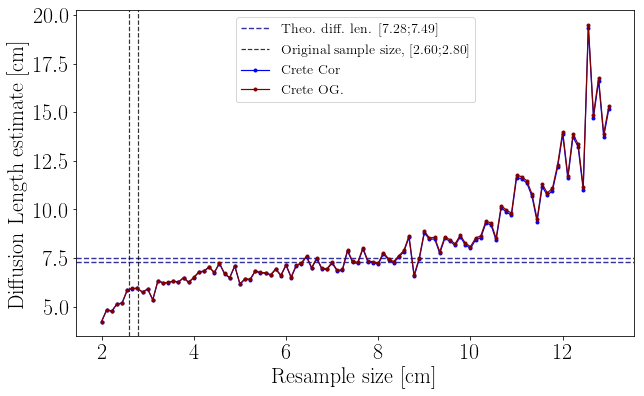

In [4]:

fig, ax = plt.subplots(figsize=(10,6))

ax.axhline(theoMin,ls='--',alpha=0.8,lw=1.4,color='navy', label=f'Theo. diff. len. [{theoMins[i]:.2f};{theoMaxs[i]:.2f}]')
ax.axhline(theoMax,ls='--',alpha=0.8,lw=1.4,color='navy')

ax.axvline(maxDiff*100,ls='--',color='k',alpha=0.8,lw=1.2, label=f'Original sample size, [{minDiff*100:.2f};{maxDiff*100:.2f}]')
ax.axvline(minDiff*100,ls='--',color='k',alpha=0.8, lw=1.2)
ax.plot(StabTest3['deltas']*100,diffLensCor*100, lw=1.2, marker='.', label=Sites[i]+' Cor', color='blue')
ax.plot(StabTest3['deltas']*100,StabTest3['diffLens']*100, lw=1.2, marker='.', label=Sites[i]+' OG.', color='maroon')
ax.set(ylabel='Diffusion Length estimate [cm]', xlabel='Resample size [cm]')
ax.legend(fontsize=14)

No ECM file found, setting empty df instead


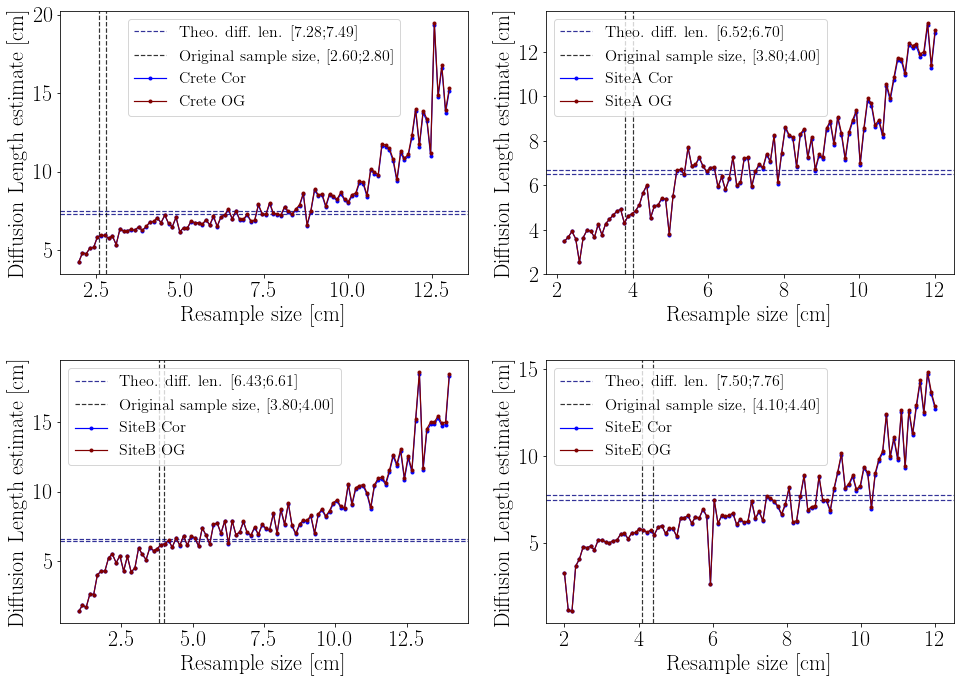

In [5]:
fig, axes = plt.subplots(2,2,figsize=(14,10))

mpl.rcParams['font.size'] = 20

for i,ax in zip(range(len(Sites)), axes.flatten()):
    DataAll = GetCoreData(Sites[i])
    data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
    depth_LT = data_d18O_LT['depth']
    d18O_LT = data_d18O_LT['d18O']

    StabTest3 = pd.read_csv('../Data/'+Sites[i] + '_DiffLensVdelta_InterpBF.txt', sep='\t')

    maxDiff = max(np.diff(depth_LT))
    minDiff = min(np.diff(depth_LT))
    
    s_deltas = (2 * (StabTest3['deltas']**2)/(np.pi**2))*np.log(np.pi/2)
    diffLensCor = StabTest3['diffLens'] - s_deltas
    
    ax.axhline(theoMins[i],ls='--',alpha=0.8,lw=1.2,color='navy', label=f'Theo. diff. len. [{theoMins[i]:.2f};{theoMaxs[i]:.2f}]')
    ax.axhline(theoMaxs[i],ls='--',alpha=0.8,lw=1.2,color='navy')
    
    ax.axvline(maxDiff*100,ls='--',color='k',alpha=0.8,lw=1.2, label=f'Original sample size, [{minDiff*100:.2f};{maxDiff*100:.2f}]')
    ax.axvline(minDiff*100,ls='--',color='k',alpha=0.8, lw=1.2)
    ax.plot(StabTest3['deltas']*100,diffLensCor*100, lw=1.2, marker='.', label=Sites[i]+' Cor', color='blue')
    ax.plot(StabTest3['deltas']*100,StabTest3['diffLens']*100, lw=1.2, marker='.', label=Sites[i]+' OG', color='maroon')
    ax.set(ylabel='Diffusion Length estimate [cm]', xlabel='Resample size [cm]')
    ax.legend(fontsize=16)
fig.tight_layout()

#fig.savefig('../WrittenWork/Figures/SamplingVsDiffLen_interpBF.jpg', bbox_inches='tight')

# Stability test: Interpolation After Deconvolution

### First, check out how interpolation looks:

#### Load core data and specifications and define all data of interest.

#### Choose core.

In [6]:
CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

coreNames = CoresSpecs['CoreName']


site = 'SiteG'

core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb = CoreSpecs['dTamb']
dLaki = CoreSpecs['dLaki']


DataAll = GetCoreData(site)

data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
data_dens = DataAll[4]; data_dens_LT = DataAll[5]
data_diff = DataAll[6]; data_diff_LT = DataAll[7]


depth_LT = data_d18O_LT['depth']
d18O_LT = data_d18O_LT['d18O']


#### Define interpolation size array from high resoultion to low resolution.
#### create empty lists to store data in.

In [7]:
delta_arr = np.arange(0.01,0.11,0.04)
diffLens = []
depths = []
datas = []
peakss = [] 
delta_arr

array([0.01, 0.05, 0.09])

#### Define instance of back diffusion class for data from specific site.

In [8]:
inst = BackDiffuse(site, data_d18O_LT, CoresSpecs, dTamb, dLaki, 32, diffLenData=data_diff_LT[['Depth','sigma_o18']], densData=data_dens_LT)
diffLen = inst.spectralEstimate()
difflenEstHL = inst.diffLenEstimateHL()
depthOG, dataOG, diffLenOG, peaksOG, arr_DiffLens, arr_Npeaks, arr_depth, arr_data = inst.backDiffused(theoDiffLen=True,print_Npeaks=False, diffLenStart_In=0.005, diffLenEnd_In=0.15, interpAfterDecon=False, newDelta=0.01)


Starting sigma: 6.66 [cm]


KeyboardInterrupt: 

In [45]:
a = 6.2#np.asarray([6.2])

if hasattr(a, "__len__"):
    print('hello')

#### For all sampling sizes (deltas) compute diffusion length resulting in 32 peaks.

In [22]:
for i in range(len(delta_arr)):
    print('\n')
    depth1, data, diffLen, peaks, arr_DiffLens, arr_Npeaks, arr_depth, arr_data = inst.backDiffused(theoDiffLen=True,print_Npeaks=False, diffLenStart_In=0.005, diffLenEnd_In=0.15, interpAfterDecon=True, newDelta=delta_arr[i])
    depths.append(depth1)
    datas.append(data)
    peakss.append(peaks)
    diffLens.append(diffLen)




Starting sigma: 6.66 [cm]
100. Npeaks: 32, diffLen: 7.668 cm
Final sigma: 8.40 [cm]
Final # of peaks: 32
Delta: 0.040
Delta new: 0.010


Starting sigma: 6.66 [cm]
100. Npeaks: 31, diffLen: 7.669 cm
200. Npeaks: 32, diffLen: 8.669 cm
Final sigma: 8.76 [cm]
Final # of peaks: 32
Delta: 0.040
Delta new: 0.050


Starting sigma: 6.66 [cm]
100. Npeaks: 28, diffLen: 7.669 cm
200. Npeaks: 32, diffLen: 8.673 cm
Final sigma: 8.88 [cm]
Final # of peaks: 32
Delta: 0.040
Delta new: 0.091


#### Plot low res, high res and OG data in same plot (for saving figures of interest)

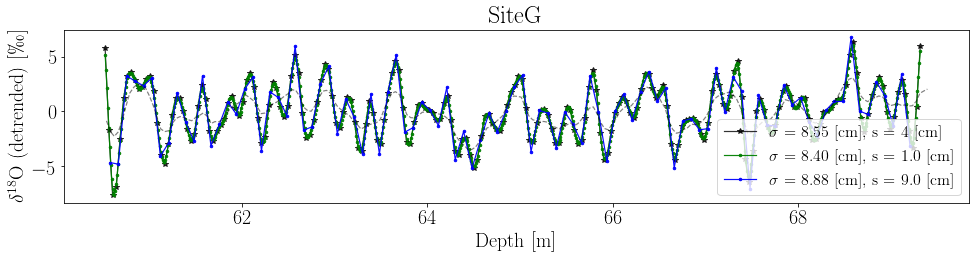

In [23]:

fig, ax = plt.subplots(figsize=(14,4))
colors = ['green','darkgreen','blue']
ax.plot(depthOG,dataOG, '-', marker='*', label=f'$\sigma$ = {diffLenOG*100:.2f} [cm], s = 4 [cm]', lw=1.2, color='k',alpha=0.8)
for i in [0,2]:#,len(delta_arr)):
    depth = depths[i]
    data = datas[i]
    ax.plot(depth,data, '-', marker='.', label=f'$\sigma$ = {diffLens[i]*100:.2f} [cm], s = {delta_arr[i]*100} [cm]', lw=1.2, color=colors[i], alpha=0.95, ms=5)
    #ax.plot(depth[peakss[i]],data[peakss[i]],'.', color='maroon', ms=10, label=f'Peaks, N = {len(peakss[i])}')
ax.set(title=site, xlabel='Depth [m]', ylabel='$\delta^{18}$O (detrended) [\permil]')
ax.legend(fontsize=16)
ax.plot(data_d18O_LT['depth'], data_d18O_LT['d18O']- np.mean(data_d18O_LT['d18O']),ls='--',label=f'Data, s = 4 [cm]', color='k', lw=1.2, alpha=0.5)

fig.tight_layout()
#fig.savefig('../WrittenWork/Figures/'+site+'ResampledAFDecon1And9cm.jpg', bbox_inches='tight')

### Then, check sampling size v. diffusion length giving N = 32 peaks

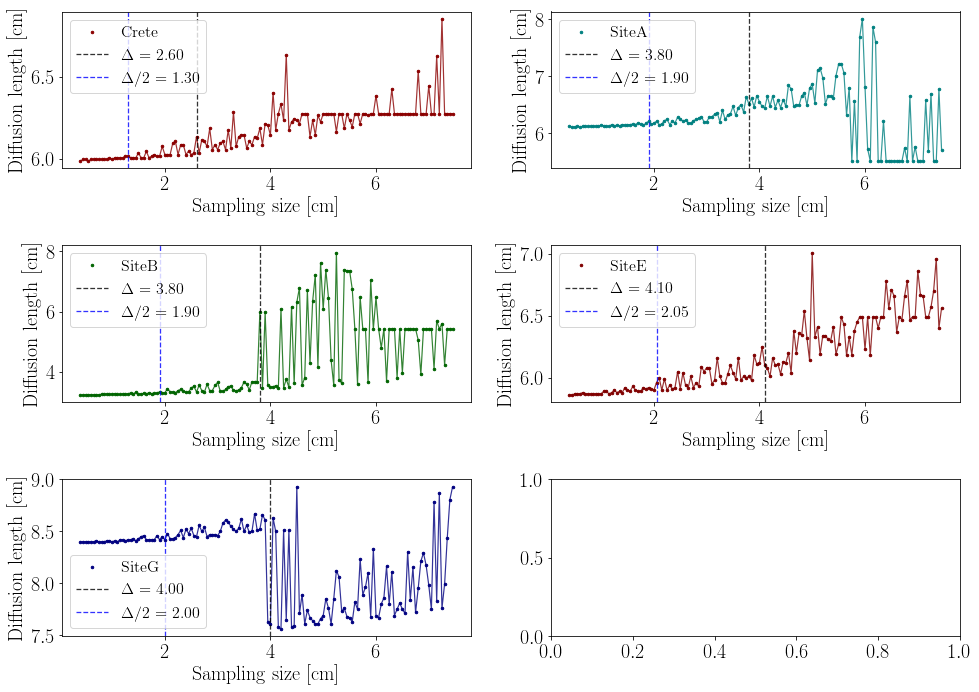

In [24]:
sites = ['Crete', 'SiteA', 'SiteB', 'SiteE', 'SiteG']
delta0s = [0.026, 0.038, 0.038, 0.041, 0.040]

colors = ['darkred','teal','darkgreen','maroon','navy']
fig,axes = plt.subplots(3,2,figsize=(14,10))#, sharex=True)#, sharey=True)

i = 0
for site, ax in zip(sites,axes.flatten()):
    Site = pd.read_csv('../Data/'+site + '_DiffLensVdelta.txt', sep='\t')

    DiffLens = Site['diffLens']
    Deltas = Site['deltas']
    ax.plot(Deltas*100, DiffLens*100,'.', marker='.', ms=5, lw=1.2, label=site, color=colors[i])
    ax.plot(Deltas*100, DiffLens*100,'-', lw=1.2,  alpha=0.8, color=colors[i],label='')
    ax.axvline(x=delta0s[i]*100, color='k',ls='--', lw=1.3, alpha=0.8, label=f'$\Delta$ = {delta0s[i]*100:.2f}')
    ax.axvline(x=(delta0s[i]/2)*100, color='b',ls='--', lw=1.3, alpha=0.8, label=f'$\Delta$/2 = {(delta0s[i]/2)*100:.2f}')
    ax.set(ylabel='Diffusion length [cm]', xlabel='Sampling size [cm]')
    ax.legend(fontsize=16)
    i+=1
    
fig.tight_layout()

#fig.savefig('../WrittenWork/Figures/SamlingVsDiffLen.jpg', bbox_inches='tight')

# Stability test: Test relationship btw number of peaks and diffusion length. 

#### Load data of specific core of interest.

In [3]:
site = 'SiteB'

CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

coreNames = CoresSpecs['CoreName']

core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb = CoreSpecs['dTamb']
dLaki = CoreSpecs['dLaki']


DataAll = GetCoreData(site)

data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
data_dens = DataAll[4]; data_dens_LT = DataAll[5]
data_diff = DataAll[6]; data_diff_LT = DataAll[7]


depth_LT = data_d18O_LT['depth']
d18O_LT = data_d18O_LT['d18O']


#### Load function to compute number of peaks for all diffusion lengths in interval [diffLen_start,diffLen_end:0.001]. 

In [4]:
from StabilityTests import getDiffLen_V_Npeaks

In [33]:

Sites = ['Crete', 'SiteA', 'SiteB', 'SiteD','SiteE', 'SiteG']
site='SiteA'
StabTest = pd.read_csv('../Data/'+site + '_DiffLensVpeaks.txt', sep='\t')

StabTest_upTo32 = pd.read_csv('../Data/'+site + '_DiffLensVpeaks_upTo32.txt', sep='\t')
StabTest_upTo32

,diffLen_upTo32,Npeaks_upTo32
0,0.005000,28
1,0.005100,28
2,0.005201,28
3,0.005301,28
4,0.005402,28
...,...,...
415,0.046708,32
416,0.046808,32
417,0.046909,32
418,0.047009,32


#### Plot number of peaks vs. diffusion length.

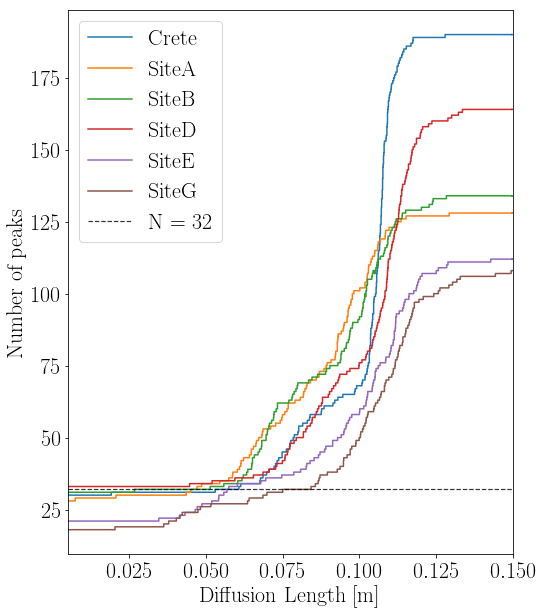

In [34]:


fig, ax = plt.subplots(figsize=(8,9))
for i in range(len(Sites)):
    StabTest = pd.read_csv('../Data/'+Sites[i] + '_DiffLensVpeaks.txt', sep='\t')
    
    ax.step(StabTest['diffLen'], StabTest['Npeaks'], label=Sites[i])
ax.axhline(y=32,ls='--',color='k', lw=1.2, alpha=0.8,label='N = 32')
ax.set(xlabel='Diffusion Length [m]', ylabel='Number of peaks', xlim=(0.005,0.15))
ax.legend()
fig.tight_layout();


#### Create zoom in plots with defined diff len resulting in < 32 peaks.

(<mpl_toolkits.axes_grid1.inset_locator.BboxPatch at 0x7fa42a498128>,
 <mpl_toolkits.axes_grid1.inset_locator.BboxConnector at 0x7fa42a4eb160>)

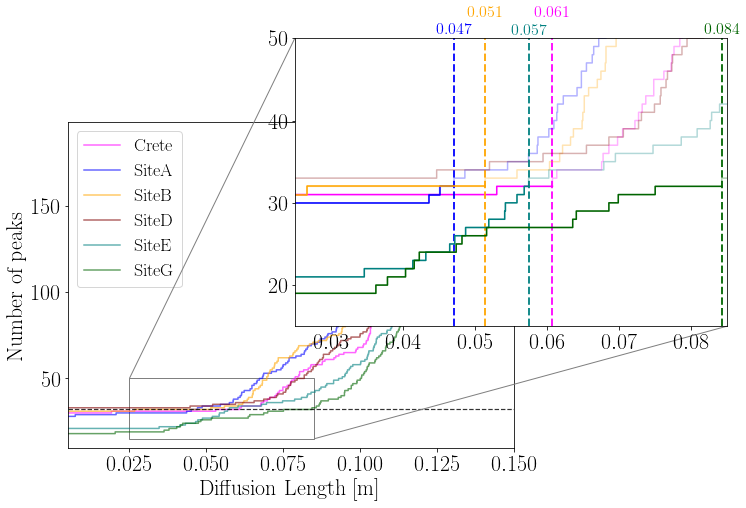

In [43]:
fig, ax = plt.subplots(figsize=(8,6))
plt.rcParams.update({'font.size': 22})
colors = ['magenta','blue','orange','maroon','teal','darkgreen']

for i in range(len(Sites)):
    StabTest = pd.read_csv('../Data/'+Sites[i] + '_DiffLensVpeaks.txt', sep='\t')
    
    ax.step(StabTest['diffLen'], StabTest['Npeaks'], label=Sites[i],alpha=0.6,color=colors[i])

ax.axhline(y=32,ls='--',color='k', lw=1.2, alpha=0.8)
ax.set(xlabel='Diffusion Length [m]', ylabel='Number of peaks', xlim=(0.005,0.15))
ax.legend(fontsize=18)



x1 = 0.025
x2 = 0.085
y1 = 15
y2 = 50


from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

axins = inset_axes(ax, 6,4, loc=2, bbox_to_anchor=(0.5,0.1,1,1), bbox_transform=ax.figure.transFigure)#loc=5) # zoom = 2
for i in range(len(Sites)):
    StabTest = pd.read_csv('../Data/'+Sites[i] + '_DiffLensVpeaks.txt', sep='\t')
    StabTest_upTo32 = pd.read_csv('../Data/'+Sites[i] + '_DiffLensVpeaks_upTo32.txt', sep='\t')
    
    DiffLens_32 = np.asarray(StabTest_upTo32['diffLen_upTo32'])
    Npeaks_32 = np.asarray(StabTest_upTo32['Npeaks_upTo32'])
    
    axins.step(StabTest['diffLen'], StabTest['Npeaks'], label=Sites[i], color=colors[i], alpha=0.3)

    if StabTest_upTo32['diffLen_upTo32'].any():
        axins.axvline(x=DiffLens_32[-1], lw=2, alpha=0.9, color=colors[i],ls='--')
        axins.step(DiffLens_32, Npeaks_32, label=Sites[i], color=colors[i])
        if (i==0)or(i==2):
            axins.text(DiffLens_32[-1]-0.0025,50+2.5, f'{DiffLens_32[-1]:.3f}',fontsize=16, color=colors[i])
        elif (i==5):
            axins.text(DiffLens_32[-1]-0.0025,50+0.5, f'{DiffLens_32[-1]:.3f}',fontsize=16, color=colors[i])
        elif (i==1)or(i==4):
            axins.text(DiffLens_32[-1]-0.0025,50+0.5, f'{DiffLens_32[-1]:.3f}',fontsize=16, color=colors[i])
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")


#fig.savefig('../WrittenWork/Figures/' + 'NpeaksVdiffLen_zoomIn.jpg', bbox_inches = 'tight')

# Test: Theoretical Diffusion Length Estimate

In [44]:
CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

coreNames = CoresSpecs['CoreName']


In [45]:
site = 'SiteA'

core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb = CoreSpecs['dTamb']
dLaki = CoreSpecs['dLaki']


DataAll = GetCoreData(site, 'Alphabet')

data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
data_dens = DataAll[4]; data_dens_LT = DataAll[5]
data_diff = DataAll[6]; data_diff_LT = DataAll[7]


depth_LT = data_d18O_LT['depth']
d18O_LT = data_d18O_LT['d18O']
N_InInt = 32

In [46]:
dataAll = pd.DataFrame({'depth':depth_LT,'d18O':d18O_LT}, index=None)

inst = BackDiffuse(site, data_d18O_LT, CoresSpecs, dTamb, dLaki, N_InInt, diffLenData=data_diff_LT[['Depth','sigma_o18']], densData=data_dens_LT)
dataMin, peaksMin, N_peaksMin, dataMax, peaksMax, N_peaksMax = inst.BackDiffuse_Theo()

depthOpt, dataOpt, diffLen, peaks, arr_DiffLens, arr_Npeaks, arr_depth, arr_data = inst.backDiffused(theoDiffLen=True,print_Npeaks=False, diffLenStart_In=0.005, diffLenEnd_In=0.15, interpAfterDecon=True)

Theo. sigma Min: 6.52 [cm]
Theo. sigma Max: 6.70 [cm]
Starting sigma: 5.52 [cm]
Final sigma: 6.14 [cm]
Final # of peaks: 32
Delta: 0.038
Delta new: 0.019


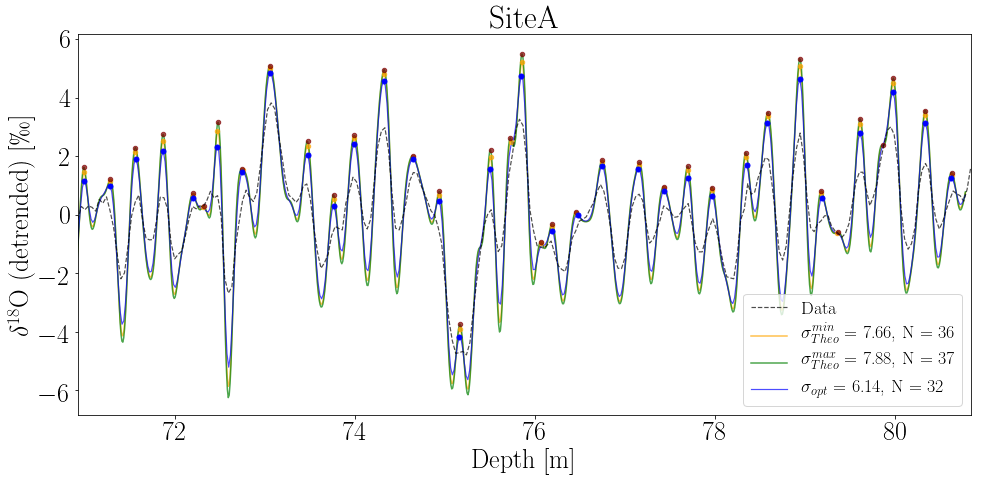

In [47]:
depth0 = dataMin['depth']
data0 = dataMin['d18O']
depth1 = dataMax['depth']
data1 = dataMax['d18O']
#troughs = signal.find_peaks(-dataOpt)[0]
mpl.rcParams['font.size'] = 26

fig, ax = plt.subplots(figsize=(16,7))

plt.plot(np.asarray(depth_LT), np.asarray(d18O_LT)-np.mean(np.asarray(d18O_LT)), lw=1.2, label='Data', ls='--', color='k', alpha=0.7)
plt.plot(depth0,data0, label='$\sigma_{Theo}^{min}$ = ' + f'7.66, N = {N_peaksMin}',zorder=-1, color='orange', alpha=0.7)
plt.plot(depth1,data1, label='$\sigma_{Theo}^{max}$ = ' + f'7.88, N = {N_peaksMax}',zorder=-1, color='green', alpha=0.7)
plt.plot(depthOpt, dataOpt, label='$\sigma_{opt}$ = ' + f'{diffLen*100:.2f}, N = {len(peaks)}',zorder=-1, color='b', alpha=.7, lw=1.2)
#, Nt = {len(troughs)}
plt.legend(fontsize=18)
ax.set(xlabel='Depth [m]', ylabel='$\delta^{18}$O (detrended) [\permil]', title=site,xlim=(min(depth_LT),max(depth_LT)))
plt.scatter(depth0[peaksMin],data0[peaksMin], color='orange',zorder=1, s=20, alpha=0.7)
plt.scatter(depth1[peaksMax],data1[peaksMax], color='maroon',zorder=1, s=20, alpha=0.7)
plt.scatter(depthOpt[peaks],dataOpt[peaks], color='b',zorder=1, s=25)
#plt.scatter(depthOpt[troughs],dataOpt[troughs], color='k',zorder=1, s=25)


#fig.savefig('../WrittenWork/Figures/'+site+'_TheoDiffLens.png', bbox_inches='tight')

In [2]:
7.88*(917.3/1000)

7.228324

# Density and diffusion profiles

In [1]:
import numpy as np
import os
import pandas as pd
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import openpyxl
import matplotlib as mpl
import scipy as sp
from scipy import stats
from scipy import signal
from scipy import fft
from scipy import io
from scipy import interpolate
from scipy import optimize
from scipy import linalg
from scipy import integrate
from scipy.fft import dct

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{textcomp}',
    r'\usepackage{wasysym}']
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.size'] = 22
mpl.rcParams['font.family'] = 'STIXGeneral'

saveFigs = False

In [2]:
import sys 
import os
sys.path.append('../')

from BackDiffuse_LT import BackDiffuse
from GetCoreData_fct import GetCoreData



from Interpolation_Class import Interpolation

In [3]:
CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')
coreNames = CoresSpecs['CoreName']
site = 'SiteA'

core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]

dTamb = CoreSpecs['dTamb']
dLaki = CoreSpecs['dLaki']
bdot0 = CoreSpecs['Accum0']
Temp0 = CoreSpecs['T0']+273.15
dens0 = CoreSpecs['dens0']
z0 = CoreSpecs['z0']


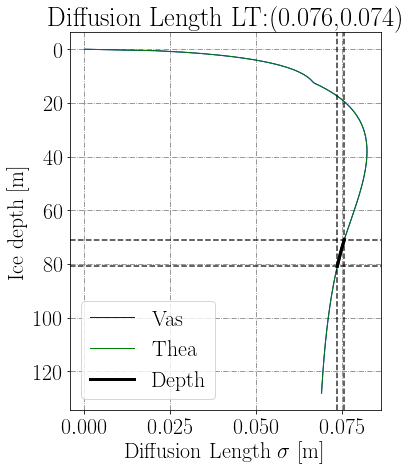

In [4]:
figDiff, axDiff= plt.subplots(figsize=(6,7))

sigmas = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/datasets/Alphabet_cores/AlphabetDiff/' + site + '_DepthDiffVas.txt','\t')
sigma_arr = sigmas['sigma_o18']
z_vec = sigmas['Depth']


sigmas2 = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/datasets/Alphabet_cores/AlphabetDiff/' + site + '_DepthDiffThea.txt','\t')
sigma_arr2 = sigmas2['sigma_o18']
z_vec2 = sigmas2['Depth']

TambDepth = dTamb
LakiDepth = dLaki
z_LT = z_vec[(z_vec >= TambDepth) & (z_vec <= LakiDepth)]
sigma_LT = np.asarray(sigma_arr[(z_vec >= TambDepth) & (z_vec <= LakiDepth)])
z_LT2 = z_vec2[(z_vec2 >= TambDepth) & (z_vec2 <= LakiDepth)]
sigma_LT2 = np.asarray(sigma_arr2[(z_vec2 >= TambDepth) & (z_vec2 <= LakiDepth)])

axDiff.invert_yaxis()
axDiff.plot(sigma_arr,z_vec, 'b', lw=1, label = 'Vas')
axDiff.plot(sigma_arr2,z_vec2, 'g', lw=1, label = 'Thea')
axDiff.plot(sigma_LT,z_LT, 'k', lw=3)
axDiff.plot(sigma_LT2,z_LT2, 'k', lw=3)
axDiff.axhline(y = TambDepth, alpha=0.8, color='k', ls='--', lw=1.5)
axDiff.axhline(y = LakiDepth, alpha=0.8, color='k', ls='--', lw=1.5)
axDiff.axvline(x = sigma_LT[0], alpha=0.8, color='k', ls='--', lw=1.5)
axDiff.axvline(x = sigma_LT[-1], alpha=0.8, color='k', ls='--', lw=1.5)
axDiff.set(xlabel='Diffusion Length $\sigma$ [m]', ylabel='Ice depth [m]',title=f'Diffusion Length LT:({sigma_LT[0]:.3f},{sigma_LT[-1]:.3f})')
axDiff.grid(True, color='grey',ls='-.')
axDiff.legend()
figDiff.tight_layout()


[(0.060195000000000005, 0.073956)]

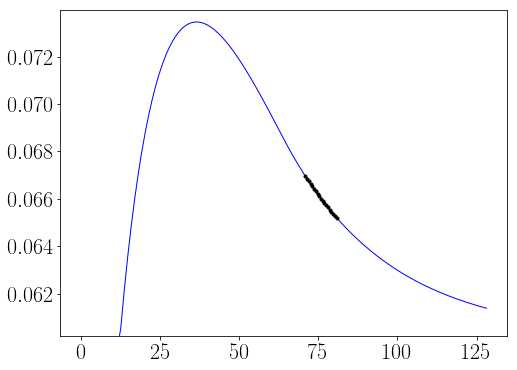

In [5]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(z_vec,sigma_arr, 'b', lw=1)
ax.plot(z_LT,sigma_LT, color='k', lw=1.2, marker='.')
ax.set(ylim=(min(sigma_LT)-0.005, max(sigma_LT)+0.007))
#ax.set(xlim=(min(z_LT)-10,max(z_LT)+10))

In [6]:
#fig, ax = plt.subplots(figsize=(6,8))
#ax.plot(z_LT,sigma_LT, color='k', lw=1.2, marker='.')

In [7]:

# Define data under examination
x_arr = z_LT
y_arr = sigma_LT

# Define objective function 
def fct(x,a,b,c):
    return a*(x**2) + b*x + c

# Fit curve to data
from scipy.optimize import curve_fit
popt, test = curve_fit(fct, x_arr, y_arr)

a, b, c = popt

In [8]:
residuals = y_arr - fct(x_arr,*popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y_arr - np.mean(y_arr))**2)
r2 = 1 - (ss_res / ss_tot)
r2

0.9999983568947208

In [9]:
core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb = CoreSpecs['dTamb']
dLaki = CoreSpecs['dLaki']


DataAll = GetCoreData(site, 'Alphabet')

data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
data_dens = DataAll[4]; data_dens_LT = DataAll[5]
data_diff = DataAll[6]; data_diff_LT = DataAll[7]


depth_LT = data_d18O_LT['depth']
d18O_LT = data_d18O_LT['d18O']
N_InInt = 32

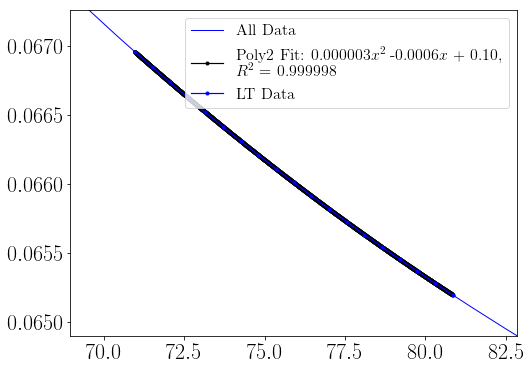

In [16]:
Npoints = 2032-1
delta = (max(z_LT) - min(z_LT))/Npoints
xTest = np.arange(min(z_LT),max(z_LT)+delta,delta)
yTest = fct(xTest, a, b, c)

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(z_vec,sigma_arr, 'b', lw=1, label='All Data')
ax.plot(xTest,yTest, color='k', lw=1.2, marker='.', label=f'Poly2 Fit: {a:.6f}$x^2$ {b:.4f}$x$ + {c:.2f}, \n$R^2$ = {r2:.6f}')
ax.plot(z_LT,sigma_LT, color='b', lw=1.2, marker='.', label='LT Data')
ax.set(ylim=(min(sigma_LT)-0.0003, max(sigma_LT)+0.0003),xlim=(min(z_LT)-2, max(z_LT)+2))
ax.legend(fontsize=16)

In [17]:
from Decon import SpectralDecon
sigmaFct = fct(xTest, *popt)-0.01
sigma1 = min(sigmaFct)
sigma1

0.055196356394038894

In [18]:
inst = SpectralDecon(np.asarray(depth_LT), np.asarray(d18O_LT),2000)

In [19]:
import scipy.fft

In [20]:

x,y=inst.deconvolve(sigmaFct)
x1,y1=inst.deconvolve(sigma1)

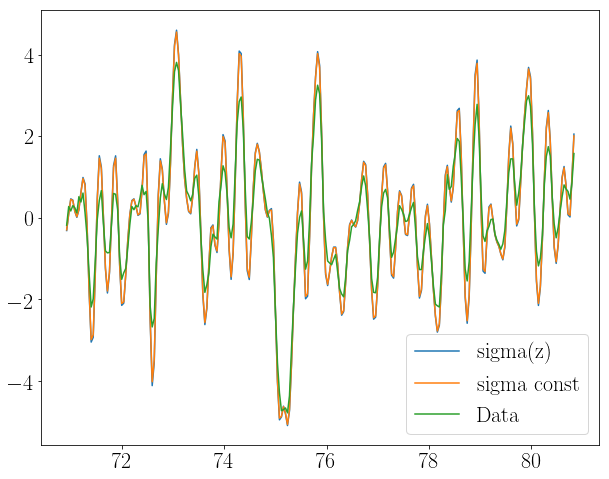

In [21]:
fig, ax = plt.subplots(figsize=(10,8))
plt.plot(x,y, label='sigma(z)')
plt.plot(x1,y1,label='sigma const')
plt.plot(depth_LT,d18O_LT-np.mean(d18O_LT),label='Data')
ax.legend()

In [22]:
from BackDiffuse_LT import BackDiffuse

In [23]:
instBD = BackDiffuse(coreName=site, d18OData=data_d18O_LT, coreSpecs=CoreSpecs, depthMin=dTamb, depthMax=dLaki, ysInSec=32, diffLenData=data_diff_LT[['Depth','sigma_o18']], densData=data_dens_LT)
test1 = instBD.backDiffused(interpBFDecon=False,interpAfterDecon=False,print_Npeaks=False)
test2 = instBD.backDiffused(interpBFDecon=True,interpAfterDecon=False,print_Npeaks=False)

Starting sigma: 5.52 [cm]
100. Npeaks: 32, diffLen: 6.520 cm
Final sigma: 6.60 [cm]
Final # of peaks: 32
Delta: 0.040
Delta new: 0.040
Starting sigma: 5.52 [cm]
Final sigma: 6.29 [cm]
Final # of peaks: 32
Delta: 0.038
Delta new: 0.038


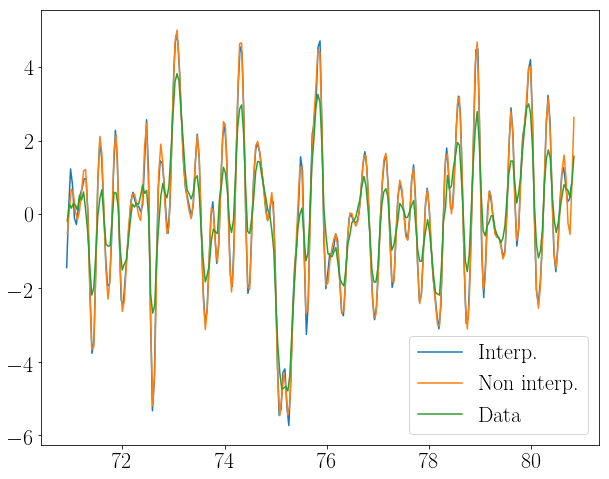

In [51]:
fig, ax = plt.subplots(figsize=(10,8))
plt.plot(test2[0],test2[1], label='Interp.')
plt.plot(test1[0],test1[1],label='Non interp.')
plt.plot(depth_LT,d18O_LT-np.mean(d18O_LT),label='Data')
ax.legend()